## Data Preperation

The dataset consists of 4 folders (1 for each classification) with about 1000 photos in each folder. Each image has marked on it if it is a left or right eye. Since we do not want the left/right of the eye to impact our results, we first take all of the right eye images and flip them, so they would be the same orientation as the left eyes

In [13]:
#show  a gallery of 2 images from each data type (left and right)
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random



In [14]:
#Since there were 3 different sources for the images not all of them are marked right/left so this step has been removed from the process

# #read in the files from ./dataset/cataract, ./dataset/diabetic_retinopathy, ./dataset/glaucoma, ./dataset/normal, look for files that have _right in the name, and flip them horizontally, then save them to a new folder. If they have _left in hte name just copy them over to the new folder with no changes
# 
# #set the path to the dataset
# path = "./dataset/"
# 
# #set the path to the new dataset
# new_path = "./processed_dataset/"
# 
# #make the new dataset folder
# os.makedirs
# 
# #loop through the folders in the dataset    
# for folder in os.listdir(path):
#     #make a new folder in the new dataset
#     os.makedirs(new_path + folder)
#     #loop through the files in the folder
#     for file in os.listdir(path + folder):
#         #read in the image
#         img = cv2.imread(path + folder + "/" + file)
#         #if the image has _right in the name, flip it horizontally
#         if "_right" in file:
#             img = cv2.flip(img, 1)
#         #remove the _right or _left from the name
#         file = file.replace("_right", "").replace("_left", "")
#         #save the image to the new folder
#         cv2.imwrite(new_path + folder + "/" + file, img)
        

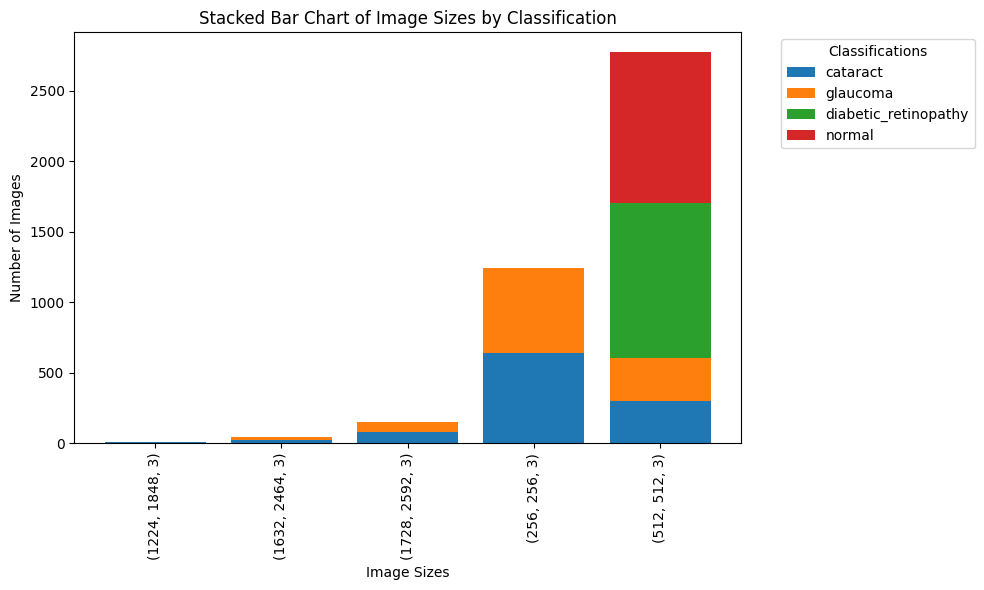

In [15]:
#set the path to the dataset
path = "./dataset/"

def create_stacked_bar_chart(path):
    """
    Create a stacked bar chart of image sizes by classification.  
    Args:
    path (str): Path to the dataset directory containing classification folders.
    """
    # Dictionary to store image size counts
    image_sizes_per_class = {}
    
    # Loop through resized dataset folders
    for folder in os.listdir(path):
        class_path = os.path.join(path, folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files
        
        image_sizes_per_class[folder] = {}

        # Loop through the files in each folder
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            img = cv2.imread(file_path)
            
            if img is None:
                continue  # skip corrupted or unreadable images
            
            # Get the size of the image
            size = str(img.shape)
            
            # Increment count for the image size
            if size in image_sizes_per_class[folder]:
                image_sizes_per_class[folder][size] += 1
            else:
                image_sizes_per_class[folder][size] = 1

    # Plot the stacked bar chart
    all_sizes = sorted(set(size for class_sizes in image_sizes_per_class.values() for size in class_sizes))
    
    bar_data = []
    class_names = list(image_sizes_per_class.keys())

    for class_name in class_names:
        class_counts = [image_sizes_per_class[class_name].get(size, 0) for size in all_sizes]
        bar_data.append(class_counts)

    bar_data = np.array(bar_data)

    fig, ax = plt.subplots(figsize=(10, 6))

    bottoms = np.zeros(len(all_sizes))
    for i, class_name in enumerate(class_names):
        ax.bar(all_sizes, bar_data[i], bottom=bottoms, label=class_name)
        bottoms += bar_data[i]

    plt.xticks(rotation=90)
    plt.xlabel('Image Sizes')
    plt.ylabel('Number of Images')
    plt.title('Stacked Bar Chart of Image Sizes by Classification')
    plt.legend(title='Classifications', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the stacked bar chart function
create_stacked_bar_chart(path)

In [16]:
def count_images_by_dimension(path, max_dimension_threshold=1000):
    """
    Counts valid and removed images in each classification based on the dimension threshold.

    Args:
    path (str): Path to the dataset directory containing classification folders.
    max_dimension_threshold (int): Maximum dimension allowed for valid images. Images with either
                                   width or height greater than this value will be counted as removed.

    Returns:
    pd.DataFrame: DataFrame containing the count of valid and removed images per classification.
    """
    
    # Dictionary to hold the count of valid images per classification
    valid_image_counts = {}
    
    # Dictionary to hold the count of removed images per classification
    removed_image_counts = {}

    # Loop through the folders in the dataset (classifications)
    for folder in os.listdir(path):
        valid_image_counts[folder] = 0
        removed_image_counts[folder] = 0
        folder_path = os.path.join(path, folder)
        
        # Check if it's a directory
        if not os.path.isdir(folder_path):
            continue
        
        # Loop through the files in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            
            # If the image is None (e.g., corrupted image), skip it
            if img is None:
                continue
            
            # Check if the image exceeds the maximum allowed dimensions
            height, width = img.shape[:2]
            if height > max_dimension_threshold or width > max_dimension_threshold:
                removed_image_counts[folder] += 1
            else:
                valid_image_counts[folder] += 1

    # Prepare the data for DataFrame
    data = {
        "Classification": valid_image_counts.keys(),
        "Valid Images": valid_image_counts.values(),
        "Removed Images": removed_image_counts.values()
    }

    # Convert to DataFrame and return
    return pd.DataFrame(data)

# Example of calling the function
dataset_path = "./dataset/"
image_counts_df = count_images_by_dimension(dataset_path, max_dimension_threshold=1000)

# Display the DataFrame
image_counts_df

,Classification,Valid Images,Removed Images
0,cataract,938,100
1,glaucoma,906,101
2,diabetic_retinopathy,1098,0
3,normal,1074,0


Since the large (not square) photos are a small subset (And they are not all centered in the rectangle), we will remove them from the dataset, along with ~100 random photos for diabetic retinopathy, and normal to keep the dataset fairly even across classifications. We will also resize the 512x512 images to 256x256 to make the dataset more manageable.

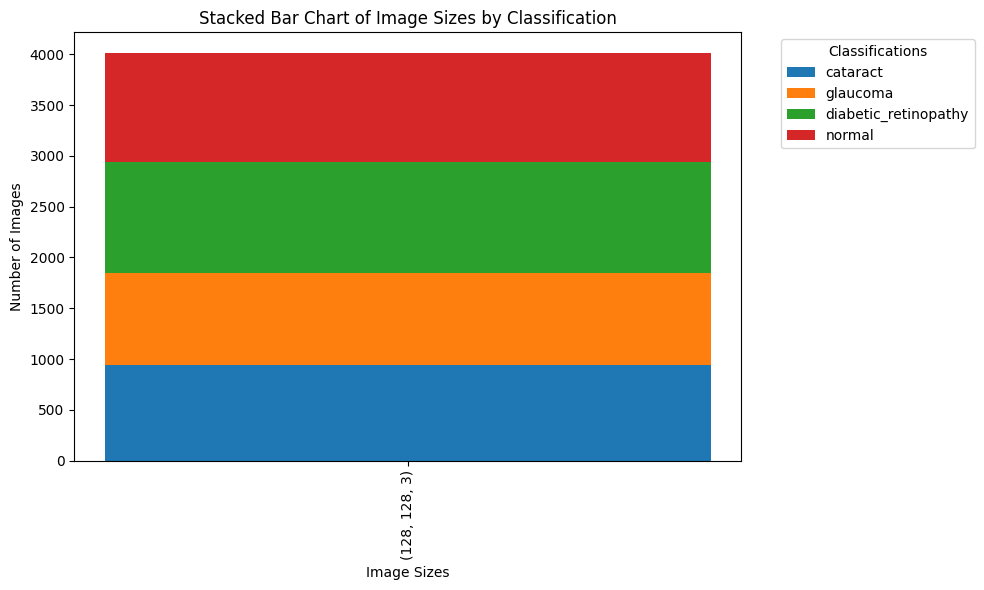

,Classification,Valid Images,Removed Images
0,cataract,938,0
1,glaucoma,906,0
2,diabetic_retinopathy,1098,0
3,normal,1074,0


In [17]:
#set the path to the dataset
path = "./dataset/"

#set the path to the new dataset
new_path = "./resized_dataset/"

# Maximum dimension threshold for removing large images (e.g., 1000 pixels in any dimension)
max_dimension_threshold = 1000

# Number of images to randomly remove from 'Normal' and 'Diabetic Retinopathy' classes
num_remove = 100

# Create the new dataset folder if it doesn't exist
os.makedirs(new_path, exist_ok=True)

# Security consideration: Ensure access is limited to the expected directory
if not os.path.isdir(path):
    raise ValueError("Dataset path is invalid.")

# Function to display before and after images with their sizes
def display_before_after(original_img, resized_img, class_name, file_name):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the original image
    ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    original_size = original_img.shape  # Get the original image size
    ax[0].set_title(f'Before - {class_name}/{file_name}\nSize: {original_size[1]}x{original_size[0]}')
    ax[0].axis('off')
    
    # Display the resized image
    ax[1].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    resized_size = resized_img.shape  # Get the resized image size (should be 256x256)
    ax[1].set_title(f'After - {class_name}/{file_name}\nSize: {resized_size[1]}x{resized_size[0]}')
    ax[1].axis('off')
    
    plt.show()

# Dictionary to track the number of images removed
removed_image_counts = {
    "large": 0,
    "Normal": 0,
    "Diabetic Retinopathy": 0
}

# Function to remove large images and downsize the rest
def process_images():
    # Loop through the folders in the dataset
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue  # skip non-directory files

        # Make a new folder in the new dataset
        new_folder_path = os.path.join(new_path, folder)
        os.makedirs(new_folder_path, exist_ok=True)

        # Remove large images
        files = os.listdir(folder_path)
        for file in files:
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            
            if img is None:
                continue  # skip unreadable or corrupted files

            height, width = img.shape[:2]
            
            # Remove large images
            if height > max_dimension_threshold or width > max_dimension_threshold:
                removed_image_counts["large"] += 1
                continue  # Do not process or save large images

            # Resize the image
            resized_img = cv2.resize(img, (128, 128))

            # Save the resized image to the new folder
            cv2.imwrite(os.path.join(new_folder_path, file), resized_img)

        # Remove additional 100 images from 'Normal' and 'Diabetic Retinopathy'
        if folder in ["Normal", "Diabetic Retinopathy"]:
            files_to_remove = random.sample(files, num_remove)
            for file in files_to_remove:
                file_path = os.path.join(new_folder_path, file)
                if os.path.exists(file_path):
                    os.remove(file_path)
                    removed_image_counts[folder] += 1

# Call the function to process the images
process_images()
create_stacked_bar_chart(new_path)
image_counts_df = count_images_by_dimension(new_path, max_dimension_threshold=1000)

# Display the DataFrame
image_counts_df

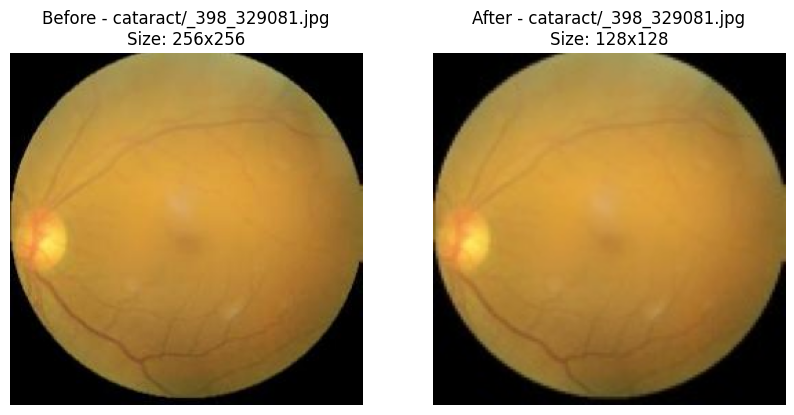

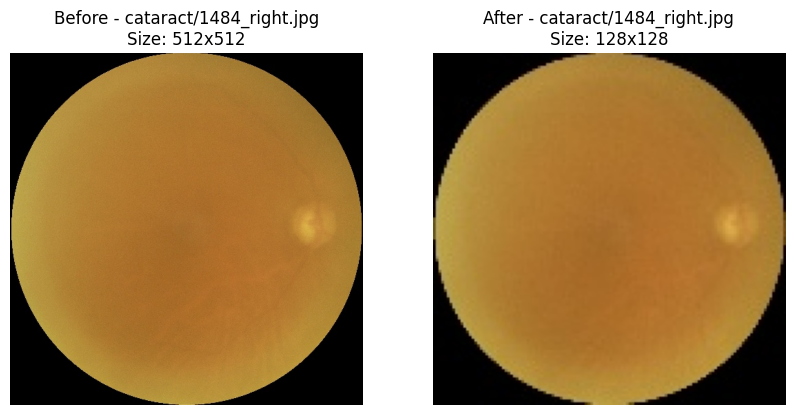

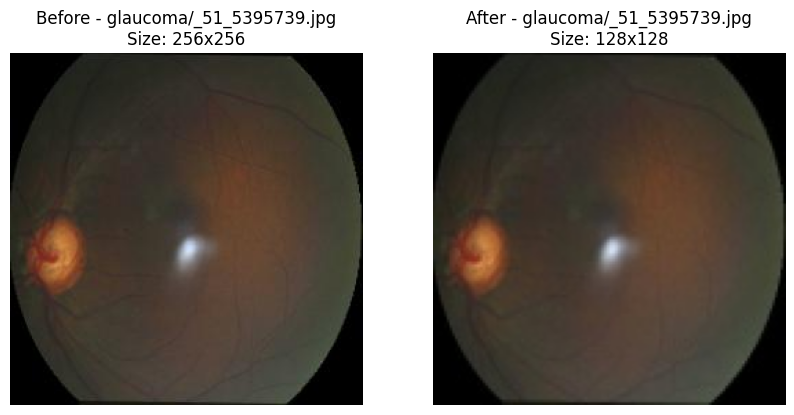

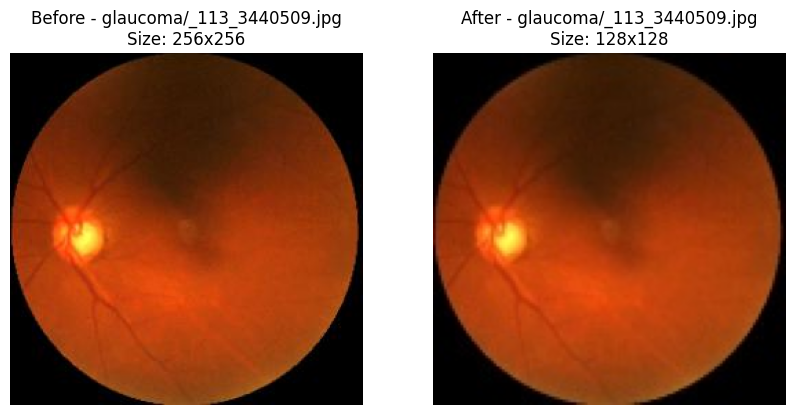

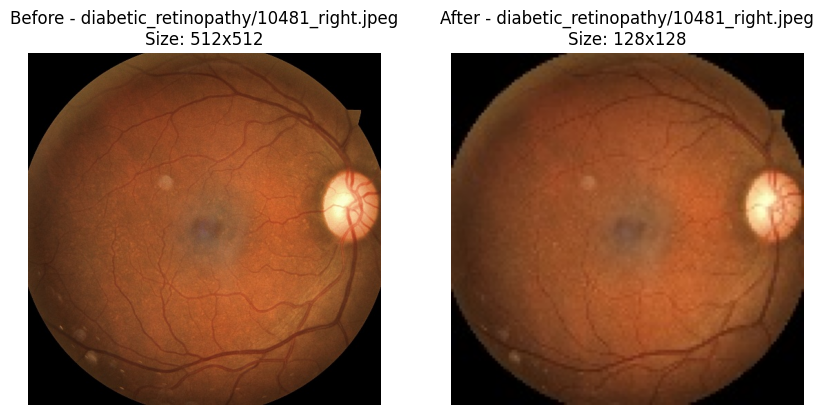

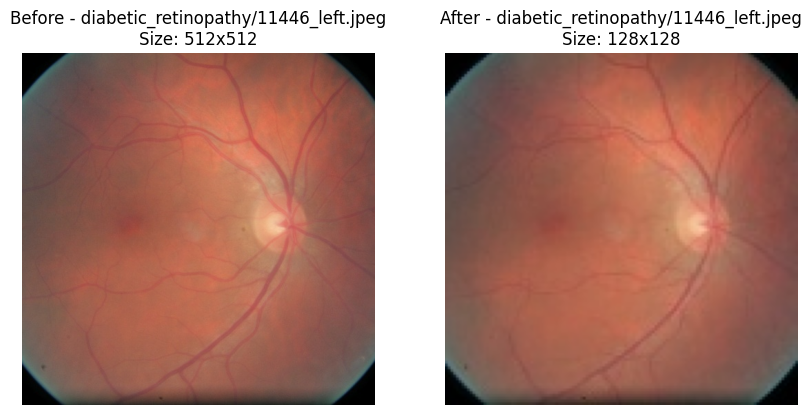

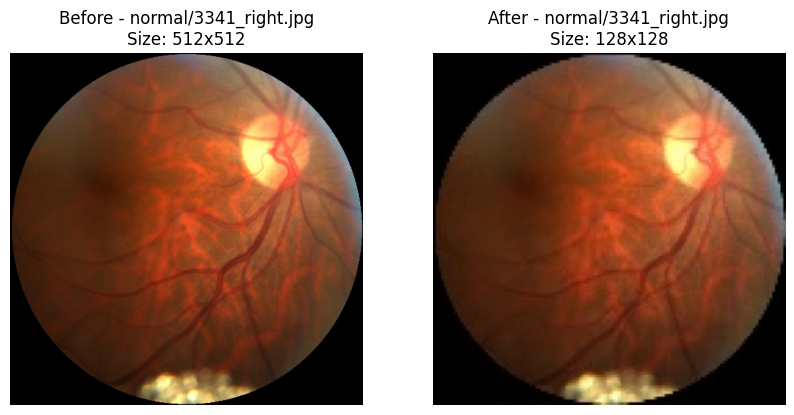

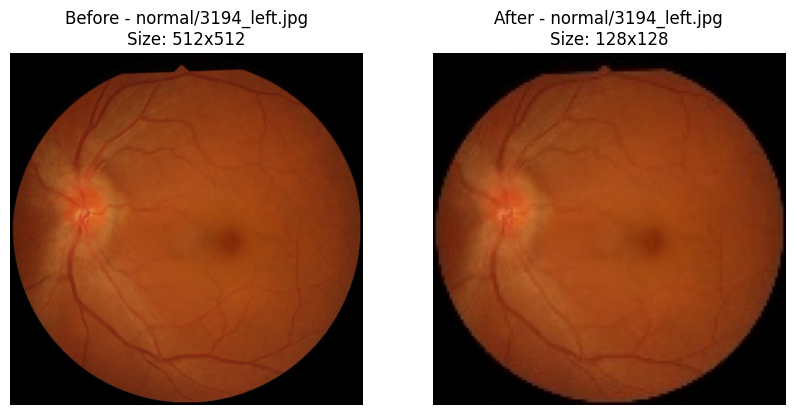

In [18]:

# Function to display before and after images with their sizes
def display_before_after(original_img, resized_img, class_name, file_name):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the original image
    ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    original_size = original_img.shape  # Get the original image size
    ax[0].set_title(f'Before - {class_name}/{file_name}\nSize: {original_size[1]}x{original_size[0]}')
    ax[0].axis('off')
    
    # Display the resized image
    ax[1].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    resized_size = resized_img.shape  # Get the resized image size (should be 256x256)
    ax[1].set_title(f'After - {class_name}/{file_name}\nSize: {resized_size[1]}x{resized_size[0]}')
    ax[1].axis('off')
    
    plt.show()

def compare_two_images_per_classification(path, new_path):
    """
    Compares two images per classification in the original dataset and the resized dataset by finding images
    with the same name in both datasets and displaying the before-and-after comparison.
    """
    
    # Loop through the folders in the dataset
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        new_folder_path = os.path.join(new_path, folder)

        if not os.path.isdir(folder_path) or not os.path.isdir(new_folder_path):
            continue
        
        # Get the files in both the original and resized dataset folders
        original_files = set(os.listdir(folder_path))
        resized_files = set(os.listdir(new_folder_path))
        
        # Find common files between the two datasets
        common_files = list(original_files.intersection(resized_files))

        # If there are fewer than 2 common files, skip this classification
        if len(common_files) < 2:
            continue
        
        # Randomly select 2 common files
        selected_files = random.sample(common_files, 2)

        # For each selected file, display the before and after comparison
        for file in selected_files:
            original_file_path = os.path.join(folder_path, file)
            resized_file_path = os.path.join(new_folder_path, file)
            
            # Read both images
            original_img = cv2.imread(original_file_path)
            resized_img = cv2.imread(resized_file_path)
            
            if original_img is None or resized_img is None:
                continue  # Skip if either image can't be read
            
            # Display the before and after comparison
            display_before_after(original_img, resized_img, folder, file)

dataset_path = "./dataset/"
resized_dataset_path = "./resized_dataset/"
compare_two_images_per_classification(dataset_path, resized_dataset_path)

In the resized images we can still clearly see features like the veins in the eye, now the images are all 128x128 and ready to be classified!

In [19]:
import cv2
import numpy as np
import os

def load_dataset_as_numpy(path, image_size=(128, 128)):
    """
    Loads a dataset of images into a NumPy array, where each row is a flattened grayscale image.
    
    Args:
    path (str): The path to the dataset.
    image_size (tuple): The size to which each image will be resized. Default is (128, 128).
    
    Returns:
    np.ndarray: A NumPy array where each row is a flattened grayscale image.
    np.ndarray: A NumPy array with the corresponding labels (classification folders).
    """
    images = []
    labels = []

    # Loop through the folders (classifications) in the dataset
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        
        if not os.path.isdir(folder_path):
            continue

        # Loop through the files in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            
            # Read the image
            img = cv2.imread(file_path)
            
            # Skip if the image is unreadable
            if img is None:
                continue
            
            # Convert the image to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Resize the image to the specified size
            img_resized = cv2.resize(img_gray, image_size)
            
            # Flatten the image (linearize)
            img_flattened = img_resized.flatten()
            
            # Append the flattened image to the images list
            images.append(img_flattened)
            
            # Append the label (folder name) to the labels list
            labels.append(folder)
    
    # Convert the lists to NumPy arrays
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    return images_np, labels_np

# Example Usage:
# Load the resized grayscale dataset as NumPy arrays
new_path = './resized_dataset/' 
X_gray, y = load_dataset_as_numpy(new_path)

# Display the shapes of the arrays
print(X_gray.shape, y.shape)


(4016, 16384) (4016,)


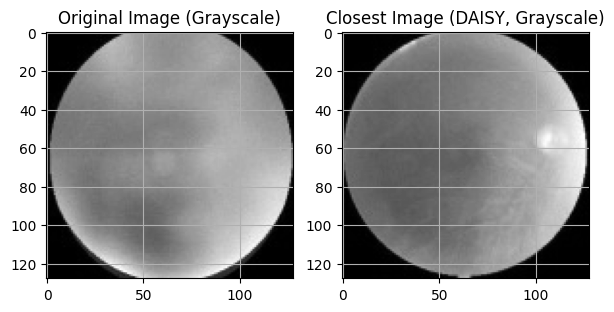

In [20]:
# DAISY Feature Extraction and Visualization for Grayscale Images
from skimage.feature import daisy
import matplotlib.pyplot as plt
import numpy as np
import copy

# Assuming the dataset `X_gray` is loaded and `h, w` are the image dimensions
h, w = 128, 128

# Function to extract DAISY features from the grayscale images
def extract_daisy_features(images, img_shape):
    features_list = []
    for img in images:
        # Reshape each image to the original grayscale shape (128, 128)
        reshaped_img = img.reshape(img_shape)
        # Extract DAISY features
        features = daisy(reshaped_img, step=10, radius=20, rings=2, histograms=8, orientations=8, visualize=False)
        features_list.append(features.reshape(-1))  # Flatten features
    return np.array(features_list)

# Apply DAISY to the grayscale dataset
daisy_features = extract_daisy_features(X_gray, (h, w))

# Calculate pairwise distances between DAISY features
from sklearn.metrics import pairwise_distances
dist_matrix_daisy = pairwise_distances(daisy_features)

# Find and visualize the closest image using DAISY features
idx1 = 5  # Index of the target image to compare
distances = copy.deepcopy(dist_matrix_daisy[idx1, :])
distances[idx1] = np.inf  # Avoid selecting the same image
idx2 = np.argmin(distances)

plt.figure(figsize=(7, 10))
plt.subplot(1, 2, 1)
# Use the correct reshaping to (h, w)
plt.imshow(X_gray[idx1].reshape((h, w)), cmap='gray')
plt.title("Original Image (Grayscale)")
plt.grid()

plt.subplot(1, 2, 2)
# Use the correct reshaping to (h, w)
plt.imshow(X_gray[idx2].reshape((h, w)), cmap='gray')
plt.title("Closest Image (DAISY, Grayscale)")
plt.grid()
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Train the KNN classifier and get predictions
knn_daisy = KNeighborsClassifier(n_neighbors=1)
daisy_train, daisy_test, y_train, y_test = train_test_split(daisy_features, y, test_size=0.2, train_size=0.8)
knn_daisy.fit(daisy_train, y_train)
y_pred = knn_daisy.predict(daisy_test)

# Overall accuracy
acc_daisy = accuracy_score(y_test, y_pred)
print(f"Daisy Features Overall Accuracy: {100*acc_daisy:.2f}%")

# Classification report for detailed category-wise performance
report = classification_report(y_test, y_pred, target_names=['Normal', 'Diabetic Retinopathy', 'Cataract', 'Glaucoma'])
print("Classification Report:\n", report)

# Confusion matrix for detailed error analysis
cm = confusion_matrix(y_test, y_pred, labels=knn_daisy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Diabetic Retinopathy', 'Cataract', 'Glaucoma'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for DAISY Features Classification")
plt.xticks(rotation=90)
plt.show()

NameError: name 'train_test_split' is not defined